<a href="https://colab.research.google.com/github/ShriShalini/Time-Series-Forecasting/blob/main/nbeats_with_extreme_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nbeats-pytorch

In [ ]:
!pip install pytorch-forecasting

In [ ]:
import pandas as pd
import numpy as np
from pytorch_forecasting.metrics import MAPE

In [ ]:
from NBEATS.NBEATS import NeuralBeats


In [ ]:
from setuptools import setup, Extension

with open('README.md', encoding='utf-8') as f:
    long_description = f.read()
    
setup(
  name = 'NBEATS',        
  packages = ['NBEATS'],   
  version = '1.3.8',     
  license='MIT',
  description="This library uses nbeats-pytorch as base and accomplishes univariate time series forecasting using N-BEATS.",
  long_description=long_description,
  long_description_content_type='text/markdown' , 
  author = 'Yazdan Khan',                   
  author_email = 'yazdan0891@gmail.com',     
  url = 'https://github.com/Y9008/NBEATS',     keywords = ['nbeats', 'timeseries', 'forecast', 'neural beats' , 'univariate timeseries forecast ', 'timeseries forecast', 'univariate timeseries forecast'],   
  install_requires=[
          'nbeats-pytorch',
      ],
  classifiers=[
    'Development Status :: 5 - Production/Stable',         
    'Topic :: Software Development :: Build Tools',
    'License :: OSI Approved :: MIT License',   
  ],
  python_requires='>=3.6'
)

In [ ]:

def try_loss(pred, true):
  #print(pred, true)
  inter = (pred - true).fill_(0)
  for i in range(0,len(inter)):
    for j in range(0,len(inter[i])):
      if((pred[i][j]<= pred.mean()+torch.std(pred) and pred[i][j]>=pred.mean()-torch.std(pred) ) and (true[i][j]>0.8 or true[i][j]<0.2)):
        inter[i][j]=torch.abs((pred[i][j]-true[i][j])*4)
  intersection = torch.abs(pred - true)
  v = (intersection+inter).mean()
  
  return v
  

In [ ]:

import os
import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.nn import functional as F
import numpy as np
from nbeats_pytorch.model import NBeatsNet 




a=[]

class NeuralBeats:   
    def __init__(self,forecast_length,data=None, backcast_length=None,save_model=False,path='',checkpoint_name='NBEATS-checkpoint.th',mode='cpu',batch_size=None,nb_blocks_per_stack=3,share_weights_in_stack=False,train_percent=0.8,hidden_layer_units=128,stack=None):
        if (data is None):
            print('For Prediction as no data passed')
            batch_size=np.nan
        else:
            self.data=data
            
        self.forecast_length=forecast_length
        if backcast_length==None:
            self.backcast_length = 60
        else:
            self.backcast_length=backcast_length
        if batch_size==None:
            self.batch_size=int(self.data.shape[0]/10)
        else:
            self.batch_size=batch_size
        self.hidden_layer_units=hidden_layer_units  
        
        if stack==None:
            self.stacks= [NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK]
        else:
            Dict = {1: NBeatsNet.GENERIC_BLOCK, 2: NBeatsNet.TREND_BLOCK , 3: NBeatsNet.SEASONALITY_BLOCK} 
            self.stacks = [Dict.get(item, item) for item in stack]

        

        self.CHECKPOINT_NAME= path+checkpoint_name
        self.device = torch.device(mode)       #change to gpu if gpu present for better performance
        self.thetas_dims=[4,8]
        self.nb_blocks_per_stack=nb_blocks_per_stack
        self.train_size=train_percent
        self.share_weights_in_stack=share_weights_in_stack

        self.net = NBeatsNet(stack_types=self.stacks,
                        forecast_length=self.forecast_length,
                        
                        nb_blocks_per_stack=self.nb_blocks_per_stack,
                        backcast_length=self.backcast_length,
                        hidden_layer_units=self.hidden_layer_units,
                        share_weights_in_stack=self.share_weights_in_stack,
                        device=self.device)
        self.parameters=self.net.parameters()
        self.global_step_cl=0
        self.check_save=save_model
        self.loaded=False
        self.saved=True
        
        
        
    def plot_scatter(self,*args, **kwargs):
        plt.plot(*args, **kwargs)
        plt.scatter(*args, **kwargs)
    
    
    def data_generator(self,x_full, y_full, bs):
        def split(arr, size):
            arrays = []
            while len(arr) > size:
                slice_ = arr[:size]
                arrays.append(slice_)
                arr = arr[size:]
            arrays.append(arr)
            return arrays
    
        while True:
            for rr in split((x_full, y_full), bs):
                yield rr    
                
    def loader(self,model, optimiser):
        if os.path.exists(self.CHECKPOINT_NAME):
            checkpoint = torch.load(self.CHECKPOINT_NAME)
            
            model.load_state_dict(checkpoint['model_state_dict'])
            optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
            grad_step = checkpoint['grad_step']
            if self.loaded:
                self.norm_constant=checkpoint['norm_constant']
            return grad_step
        return 0
    
    def saver(self,model, optimiser, grad_step):
        if self.saved:
                 torch.save({
                'norm_constant':self.norm_constant, 
                'grad_step': grad_step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
            }, self.CHECKPOINT_NAME) 
        else:            
            torch.save({
                'grad_step': grad_step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimiser.state_dict(),
            }, self.CHECKPOINT_NAME) 
    
    
    def load(self,file=None,optimiser=None):
         if file==None:
            raise Exception('Empty File Name')
         elif file=='':
            raise Exception('Empty File Name') 
         else:
           if optimiser==None:
            self.optimiser = optim.Adam(self.net.parameters())
           else:
               self.optimiser = optimiser
           self.CHECKPOINT_NAME=file
           self.loaded=True
           self.global_step_cl=self.loader(self.net,self.optimiser)
           self.CHECKPOINT_NAME='nbeats-training-checkpoint.th'
        
            
        
    def save(self,file=None):
        if file==None:
            raise Exception('Empty File Name')
        elif file=='':
            raise Exception('Empty File Name')            
        else:
            self.CHECKPOINT_NAME=file
            self.saver(self.net,self.optimiser,self.global_step_cl)
            self.saved=True

           
    def train_100_grad_steps(self,data, test_losses):
        if not self.loaded:
            global_step = self.loader(self.net, self.optimiser)
            self.loaded=False
            self.global_step_cl=global_step
        for x_train_batch, y_train_batch in data:
            #print("Xtrain", x_train_batch, x_train_batch.shape)
            #print("ytrain", y_train_batch, y_train_batch.shape)
            self.global_step_cl += 1
            self.optimiser.zero_grad()
            self.net.train()
            _, forecast = self.net(torch.tensor(x_train_batch, dtype=torch.float).to(self.device))
            loss = try_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(self.device))
            loss.backward()
            self.optimiser.step()
            if self.verbose:
                if self.global_step_cl % 30 == 0:
                    print(f'grad_step = {str(self.global_step_cl).zfill(6)}, tr_loss = {loss.item():.6f}, te_loss = {test_losses[-1]:.6f}')
            if self.global_step_cl > 0 and self.global_step_cl % 100 == 0:
                with torch.no_grad():
                   self.saver(self.net, self.optimiser, self.global_step_cl)
                break
        return forecast   
    
    def eval_test(self, test_losses, x_test, y_test):
        self.net.eval()
        _, forecast = self.net(torch.tensor(x_test, dtype=torch.float))
        test_losses.append(try_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item())
        target = torch.tensor(y_test, dtype=torch.float)
        m = MAPE()
        a.append(m.loss(forecast, target).mean().item())
        #print("mape",forecast, torch.tensor(y_test, dtype=torch.float))
        #print(type(forecast), type(torch.tensor(y_test, dtype=torch.float)))
        p = forecast.detach().numpy()
        if self.plot:
            subplots = [221, 222, 223, 224]
            plt.figure(1)
            for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
                ff, xx, yy = p[i] * self.norm_constant, x_test[i] * self.norm_constant, y_test[i] * self.norm_constant
                plt.subplot(subplots[plot_id])
                plt.grid()
                self.plot_scatter(range(0, self.backcast_length), xx, color='b')
                self.plot_scatter(range(self.backcast_length, self.backcast_length + self.forecast_length), yy, color='g')
                self.plot_scatter(range(self.backcast_length, self.backcast_length + self.forecast_length), ff, color='r')
            plt.show()
        
        
    def fit(self,epoch=25,optimiser=None,plot=True,verbose=True):
        self.plot=plot
        self.verbose=verbose
        
        self.epoch=epoch
        self.norm_constant = np.max(self.data)
        self.data = self.data / self.norm_constant 
        x_train_batch, y,self.x_forecast = [], [] ,[]
        for i in range(self.backcast_length, len(self.data) - self.forecast_length):
            x_train_batch.append(self.data[i - self.backcast_length:i])
            y.append(self.data[i:i + self.forecast_length])
            self.x_forecast.append(self.data[i+1 - self.backcast_length:i+1])
            i=i+self.forecast_length
        x_train_batch = np.array(x_train_batch)[..., 0]
        self.x_forecast = np.array(self.x_forecast)[..., 0]

        y = np.array(y)[..., 0]
        if optimiser==None:
            self.optimiser = optim.Adam(self.net.parameters())
        else:
            self.optimiser = optimiser
        
        c = int(len(x_train_batch) * self.train_size)
        x_train, y_train = x_train_batch[:c], y[:c]
        x_test, y_test = x_train_batch[c:], y[c:]

        train_data = self.data_generator(x_train, y_train, self.batch_size)
        test_losses = []
        for i in range(self.epoch):
            self.eval_test(test_losses, x_test, y_test)
            self.train_100_grad_steps(train_data, test_losses)
        if self.check_save:
            pass
        else:
            if os.path.exists(self.CHECKPOINT_NAME):
                os.remove(self.CHECKPOINT_NAME)
            
    def predict(self,predict_data=None):        
        if (predict_data is None):
            print("If statement")
            _, forecasted_values = self.net(torch.tensor(self.x_forecast, dtype=torch.float))
            forecasted_values= forecasted_values.detach().numpy()
            forecasted_values = forecasted_values * self.norm_constant
        else:
            print("else statement")
            if (predict_data.shape[0]!=self.backcast_length):
                raise Exception('Numpy array for prediction input should be of backcast_length: {} x 1 shape'.format(self.backcast_length))
            else:
                predict_data=predict_data/self.norm_constant
                predict_data= np.reshape(predict_data, (self.backcast_length, 1)) 
                
                _, forecasted_values = self.net(torch.tensor(predict_data.T, dtype=torch.float))
                forecasted_values= forecasted_values.detach().numpy()
                forecasted_values = forecasted_values * self.norm_constant
                
        return forecasted_values.T

In [ ]:
forecast_len = 60
backcast_len = 7
test_len=100
p =len(d)-test_len
p=int(p)
d[0:p]

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=60, forecast_length=7, share_thetas=False) at @140369871796752
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=60, forecast_length=7, share_thetas=False) at @140369881278416
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=60, forecast_length=7, share_thetas=False) at @140369880989840
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=60, forecast_length=7, share_thetas=True) at @140369881278288
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=60, forecast_length=7, share_thetas=True) at @140369886046544
     | -- SeasonalityBlock(units=128, thetas_dim=7, backcast_length=60, forecast_length=7, share_thetas=True) at @140369881210960


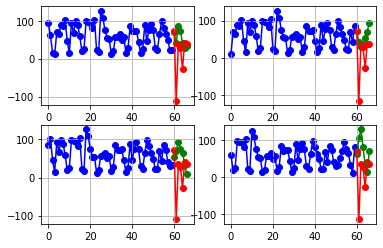

grad_step = 000030, tr_loss = 0.152599, te_loss = 0.506150
grad_step = 000060, tr_loss = 0.101554, te_loss = 0.506150
grad_step = 000090, tr_loss = 0.059827, te_loss = 0.506150


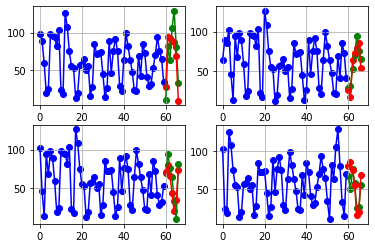

grad_step = 000120, tr_loss = 0.054778, te_loss = 0.122327
grad_step = 000150, tr_loss = 0.043110, te_loss = 0.122327
grad_step = 000180, tr_loss = 0.032372, te_loss = 0.122327


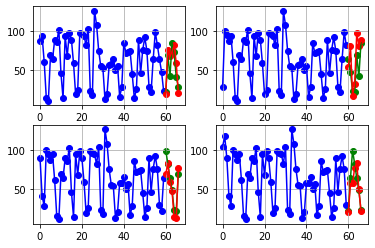

grad_step = 000210, tr_loss = 0.031183, te_loss = 0.134639
grad_step = 000240, tr_loss = 0.029877, te_loss = 0.134639
grad_step = 000270, tr_loss = 0.017618, te_loss = 0.134639
grad_step = 000300, tr_loss = 0.020919, te_loss = 0.134639


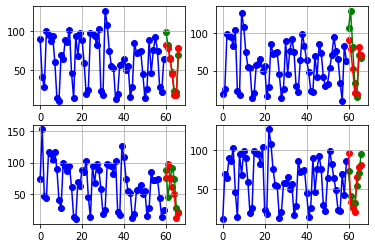

grad_step = 000330, tr_loss = 0.016637, te_loss = 0.129327
grad_step = 000360, tr_loss = 0.019157, te_loss = 0.129327
grad_step = 000390, tr_loss = 0.016804, te_loss = 0.129327


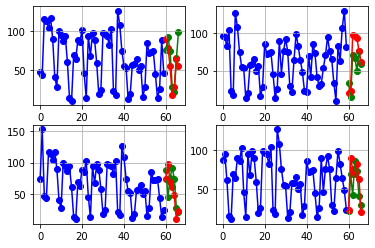

grad_step = 000420, tr_loss = 0.023190, te_loss = 0.132919
grad_step = 000450, tr_loss = 0.012520, te_loss = 0.132919
grad_step = 000480, tr_loss = 0.016469, te_loss = 0.132919


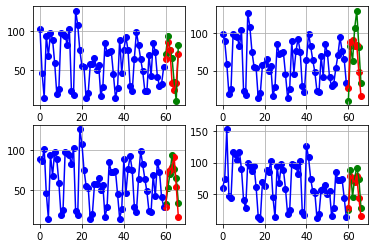

grad_step = 000510, tr_loss = 0.014122, te_loss = 0.129488
grad_step = 000540, tr_loss = 0.020154, te_loss = 0.129488
grad_step = 000570, tr_loss = 0.012225, te_loss = 0.129488
grad_step = 000600, tr_loss = 0.014060, te_loss = 0.129488


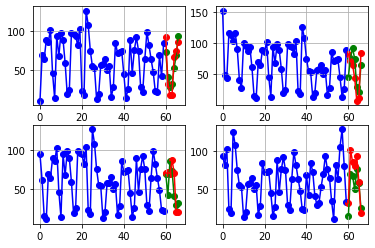

grad_step = 000630, tr_loss = 0.015268, te_loss = 0.117898
grad_step = 000660, tr_loss = 0.013146, te_loss = 0.117898
grad_step = 000690, tr_loss = 0.012491, te_loss = 0.117898


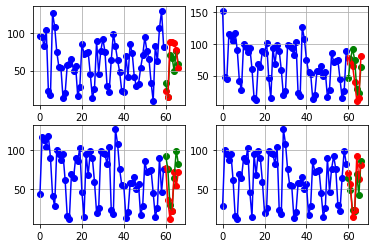

grad_step = 000720, tr_loss = 0.014486, te_loss = 0.112305
grad_step = 000750, tr_loss = 0.010670, te_loss = 0.112305
grad_step = 000780, tr_loss = 0.008329, te_loss = 0.112305


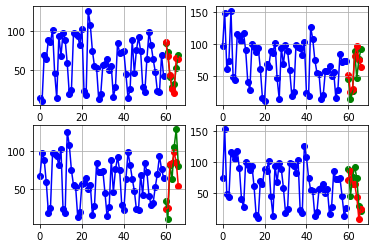

grad_step = 000810, tr_loss = 0.012029, te_loss = 0.107830
grad_step = 000840, tr_loss = 0.012454, te_loss = 0.107830
grad_step = 000870, tr_loss = 0.009730, te_loss = 0.107830
grad_step = 000900, tr_loss = 0.012763, te_loss = 0.107830


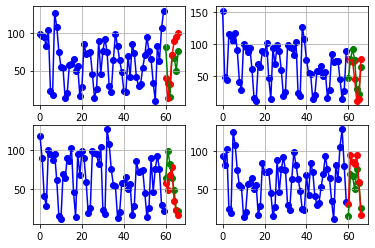

grad_step = 000930, tr_loss = 0.013859, te_loss = 0.108264
grad_step = 000960, tr_loss = 0.013017, te_loss = 0.108264
grad_step = 000990, tr_loss = 0.009352, te_loss = 0.108264


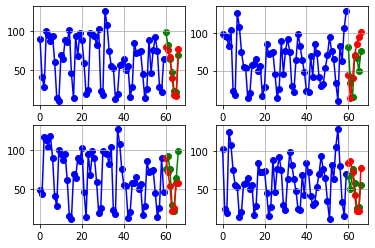

grad_step = 001020, tr_loss = 0.009024, te_loss = 0.117182
grad_step = 001050, tr_loss = 0.009736, te_loss = 0.117182
grad_step = 001080, tr_loss = 0.009007, te_loss = 0.117182


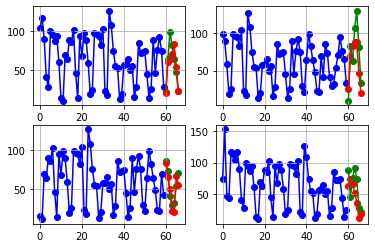

grad_step = 001110, tr_loss = 0.009567, te_loss = 0.110234
grad_step = 001140, tr_loss = 0.008863, te_loss = 0.110234
grad_step = 001170, tr_loss = 0.011420, te_loss = 0.110234
grad_step = 001200, tr_loss = 0.007913, te_loss = 0.110234


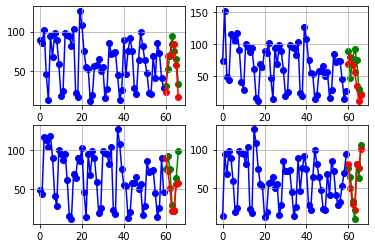

grad_step = 001230, tr_loss = 0.009569, te_loss = 0.114281
grad_step = 001260, tr_loss = 0.006566, te_loss = 0.114281
grad_step = 001290, tr_loss = 0.006996, te_loss = 0.114281


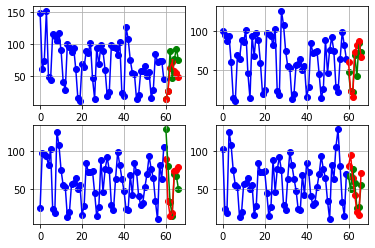

grad_step = 001320, tr_loss = 0.009025, te_loss = 0.103561
grad_step = 001350, tr_loss = 0.014115, te_loss = 0.103561
grad_step = 001380, tr_loss = 0.007614, te_loss = 0.103561


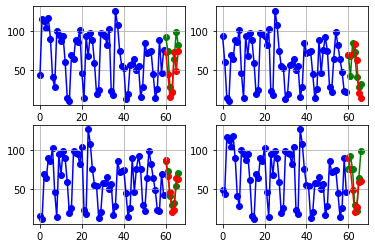

grad_step = 001410, tr_loss = 0.008943, te_loss = 0.105051
grad_step = 001440, tr_loss = 0.010361, te_loss = 0.105051
grad_step = 001470, tr_loss = 0.008558, te_loss = 0.105051
grad_step = 001500, tr_loss = 0.006672, te_loss = 0.105051


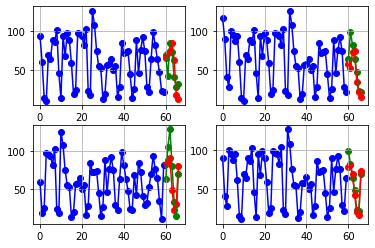

grad_step = 001530, tr_loss = 0.009915, te_loss = 0.104464
grad_step = 001560, tr_loss = 0.008156, te_loss = 0.104464
grad_step = 001590, tr_loss = 0.012324, te_loss = 0.104464


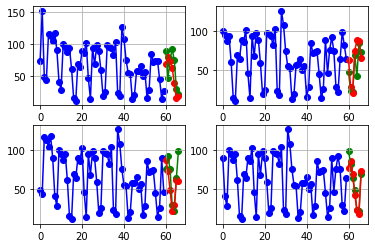

grad_step = 001620, tr_loss = 0.010781, te_loss = 0.110878
grad_step = 001650, tr_loss = 0.008810, te_loss = 0.110878
grad_step = 001680, tr_loss = 0.006273, te_loss = 0.110878


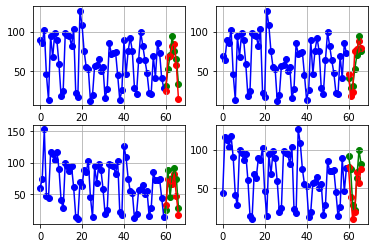

grad_step = 001710, tr_loss = 0.008010, te_loss = 0.100865
grad_step = 001740, tr_loss = 0.008531, te_loss = 0.100865
grad_step = 001770, tr_loss = 0.007084, te_loss = 0.100865
grad_step = 001800, tr_loss = 0.008599, te_loss = 0.100865


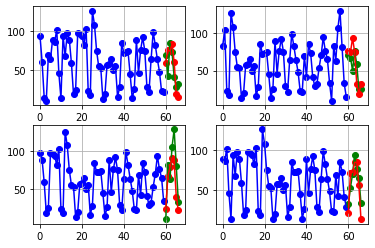

grad_step = 001830, tr_loss = 0.006905, te_loss = 0.108648
grad_step = 001860, tr_loss = 0.006136, te_loss = 0.108648
grad_step = 001890, tr_loss = 0.008053, te_loss = 0.108648


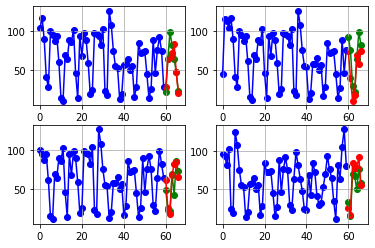

grad_step = 001920, tr_loss = 0.006087, te_loss = 0.108055
grad_step = 001950, tr_loss = 0.004906, te_loss = 0.108055
grad_step = 001980, tr_loss = 0.005878, te_loss = 0.108055


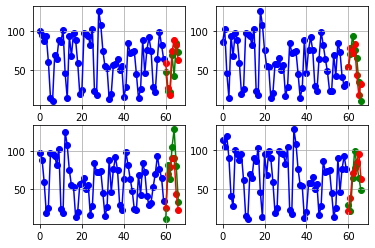

grad_step = 002010, tr_loss = 0.005464, te_loss = 0.108155
grad_step = 002040, tr_loss = 0.005571, te_loss = 0.108155
grad_step = 002070, tr_loss = 0.004932, te_loss = 0.108155
grad_step = 002100, tr_loss = 0.007807, te_loss = 0.108155


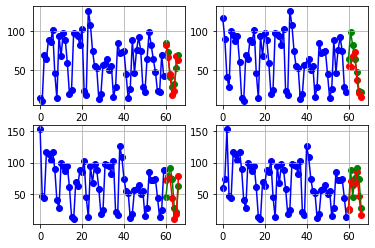

grad_step = 002130, tr_loss = 0.006599, te_loss = 0.108495
grad_step = 002160, tr_loss = 0.007713, te_loss = 0.108495
grad_step = 002190, tr_loss = 0.007965, te_loss = 0.108495


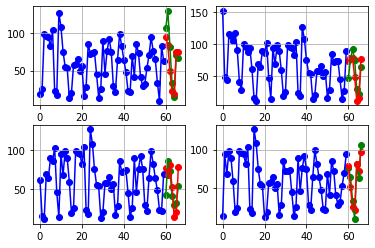

grad_step = 002220, tr_loss = 0.009398, te_loss = 0.110312
grad_step = 002250, tr_loss = 0.008495, te_loss = 0.110312
grad_step = 002280, tr_loss = 0.008043, te_loss = 0.110312


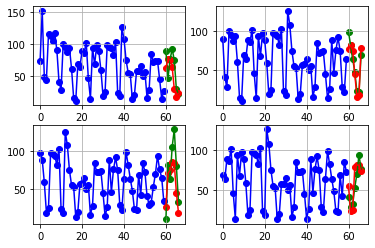

grad_step = 002310, tr_loss = 0.009277, te_loss = 0.103904
grad_step = 002340, tr_loss = 0.007902, te_loss = 0.103904
grad_step = 002370, tr_loss = 0.008561, te_loss = 0.103904
grad_step = 002400, tr_loss = 0.010704, te_loss = 0.103904


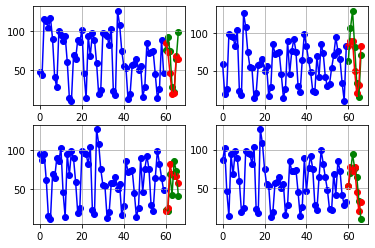

grad_step = 002430, tr_loss = 0.007321, te_loss = 0.108797
grad_step = 002460, tr_loss = 0.006836, te_loss = 0.108797
grad_step = 002490, tr_loss = 0.007142, te_loss = 0.108797


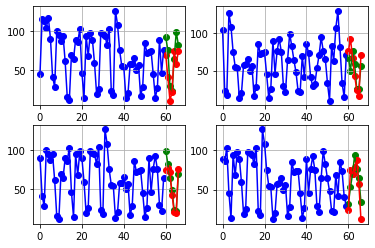

grad_step = 002520, tr_loss = 0.006787, te_loss = 0.103070
grad_step = 002550, tr_loss = 0.006298, te_loss = 0.103070
grad_step = 002580, tr_loss = 0.005200, te_loss = 0.103070


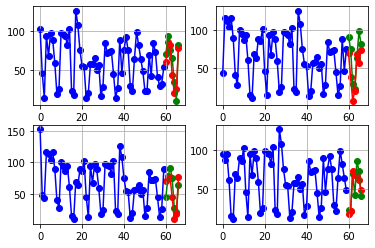

grad_step = 002610, tr_loss = 0.006094, te_loss = 0.102845
grad_step = 002640, tr_loss = 0.006083, te_loss = 0.102845
grad_step = 002670, tr_loss = 0.006620, te_loss = 0.102845
grad_step = 002700, tr_loss = 0.006409, te_loss = 0.102845


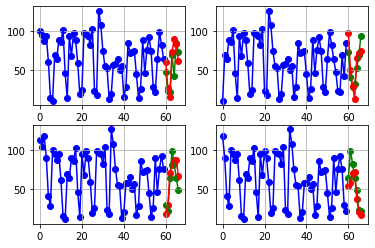

grad_step = 002730, tr_loss = 0.004219, te_loss = 0.097997
grad_step = 002760, tr_loss = 0.005616, te_loss = 0.097997
grad_step = 002790, tr_loss = 0.006312, te_loss = 0.097997


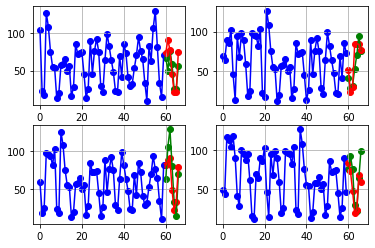

grad_step = 002820, tr_loss = 0.008599, te_loss = 0.108207
grad_step = 002850, tr_loss = 0.009601, te_loss = 0.108207
grad_step = 002880, tr_loss = 0.006066, te_loss = 0.108207


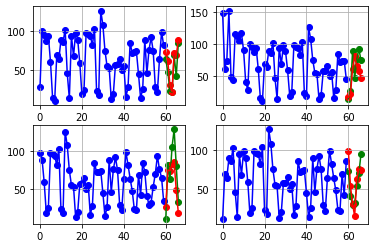

grad_step = 002910, tr_loss = 0.005614, te_loss = 0.111791
grad_step = 002940, tr_loss = 0.007837, te_loss = 0.111791
grad_step = 002970, tr_loss = 0.007809, te_loss = 0.111791
grad_step = 003000, tr_loss = 0.005768, te_loss = 0.111791


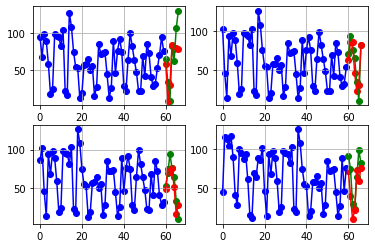

grad_step = 003030, tr_loss = 0.005199, te_loss = 0.107165
grad_step = 003060, tr_loss = 0.007372, te_loss = 0.107165
grad_step = 003090, tr_loss = 0.008063, te_loss = 0.107165


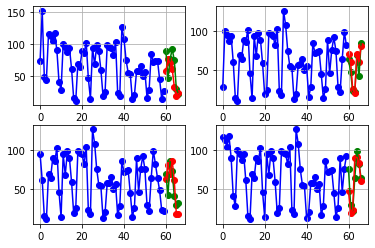

grad_step = 003120, tr_loss = 0.006842, te_loss = 0.106001
grad_step = 003150, tr_loss = 0.003934, te_loss = 0.106001
grad_step = 003180, tr_loss = 0.008320, te_loss = 0.106001


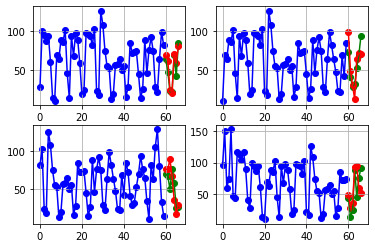

grad_step = 003210, tr_loss = 0.005824, te_loss = 0.106678
grad_step = 003240, tr_loss = 0.005860, te_loss = 0.106678
grad_step = 003270, tr_loss = 0.006111, te_loss = 0.106678
grad_step = 003300, tr_loss = 0.006185, te_loss = 0.106678


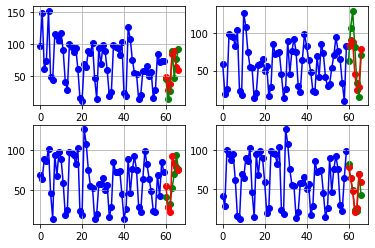

grad_step = 003330, tr_loss = 0.006787, te_loss = 0.105991
grad_step = 003360, tr_loss = 0.007015, te_loss = 0.105991
grad_step = 003390, tr_loss = 0.006592, te_loss = 0.105991


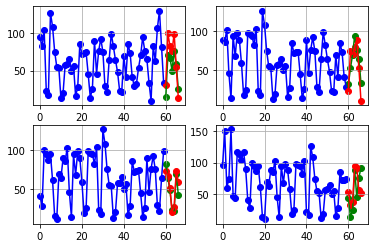

grad_step = 003420, tr_loss = 0.005756, te_loss = 0.111669
grad_step = 003450, tr_loss = 0.005536, te_loss = 0.111669
grad_step = 003480, tr_loss = 0.005818, te_loss = 0.111669


In [ ]:
data = pd.read_csv('ai_count_no_ouliers.csv')   
data = data.values # nx1(numpy array)
data = np.delete(data, [0,1], 1)
d = np.vstack(data).astype(np.float)
model=NeuralBeats(data=d[0:p],forecast_length=7,stack=[1,3],nb_blocks_per_stack=3)

#or use prebuilt models
#model.load(file='NBEATS.th')


#use customised optimiser with parameters
model.fit(epoch=35,optimiser=optim.AdamW(model.parameters, lr=0.01, betas=(0.9, 0.999), eps=1e-07, weight_decay=0.01, amsgrad=False)) 
#or 
#model.fit()



In [ ]:
forecast_len = 60
backcast_len = 7
test_len=100

In [ ]:
m = MAPE()
#        a.append(m.loss(forecast, target).mean().item())
test_error = []
j=0
for i in range(len(d)-test_len,len(d)-forecast_len):
  if(i+(forecast_len+backcast_len) > len(d)):
    break
  print(j)
  forecast=model.predict(predict_data=d[i:i+forecast_len])
  test_error.append(m.loss(torch.from_numpy(forecast),torch.from_numpy(d[i+forecast_len:i+(forecast_len+backcast_len)] )).mean().item())
  j=j+1

In [ ]:
sum(test_error)/len(test_error)

0.7795486607772041